In [106]:
import os
import requests
import json
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm

load_dotenv()

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", [(0, "#db404c"), (0.5, "#ffffff"), (1, "#428195")]
)
import torch

import torch.nn.functional as F

# Define Embeddings Function

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings_provider = "ollama"  # "transformers" or "ollama"

In [108]:
if embeddings_provider == "transformers":
    from transformers import AutoTokenizer, AutoModel

    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained(
        "nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True
    )
    model.eval()
    model = model.to(device)

    def mean_pooling(model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        )
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
            input_mask_expanded.sum(1), min=1e-9
        )

    def get_text_embeddings(text, norm=False):
        """
        Gets the text embeddings for the given text.

        Args:
            text (str): The text to get embeddings for.

        Returns:
            list: The text embeddings as a list.
        """
        encoded_input = tokenizer(
            [text], padding=True, truncation=True, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)

        embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
        if norm:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings.cpu().squeeze(0).numpy().tolist()

elif embeddings_provider == "ollama":

    def get_text_embeddings(text):
        """
        Sends a POST request to a local API to get embeddings for the given text.

        Parameters:
        text (str): The text for which to get embeddings.

        Returns:
        list: The embeddings for the given text as a list of floats.
        """
        url = "http://localhost:11434/api/embeddings"
        data = {"model": "0ssamaak0/nomic-embed-text", "prompt": text}
        response = requests.post(url, data=json.dumps(data))
        return response.json()["embedding"]

# Vector Database

In [109]:
import chromadb

chroma_client = chromadb.PersistentClient("db/")
collection = chroma_client.get_or_create_collection(
    name="emotions_cosine", metadata={"hnsw:space": "cosine"}
)

# Get definitions

In [110]:
import yaml

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
emotions = config["EMOTIONS"]
id2label = {str(id): label for id, label in enumerate(emotions)}
label2id = {v: k for k, v in id2label.items()}

## GoEmotions Definitions

In [193]:
GPTEd = {
    "Amusement": "I couldn't stop laughing at the antics of the playful kitten, each of its clumsy jumps bringing tears of mirth to my eyes.",
    "Excitement": "The thrill of anticipation surged through me as I stood in line for the roller coaster, my heart racing with the promise of exhilarating speed and gravity-defying loops.",
    "Joy": "A radiant smile spread across my face as I watched the golden sunrise, the warmth of the first light filling me with an overwhelming sense of happiness.",
    "Love": "As I gazed into your eyes, I felt an unbreakable bond of affection and devotion, a love so profound that it seemed to transcend time and space.",
    "Desire": "An intense longing filled my heart as I gazed at the distant horizon, yearning to explore the vast and mysterious world beyond my reach.",
    "Optimism": "Despite the challenges ahead, I felt a buoyant sense of hope and confidence, believing that the future held endless possibilities for success and happiness.",
    "Caring": "With gentle hands and a tender heart, I soothed the crying child, my concern for their well-being enveloping me in a warm, protective embrace.",
    "Pride": "As I stood on the podium, the applause of the crowd echoing in my ears, a deep sense of pride swelled within me, celebrating my hard-earned accomplishments.",
    "Admiration": "I watched in awe as the artist deftly painted, each brushstroke revealing a masterpiece, my admiration for their skill and creativity growing with every passing moment.",
    "Gratitude": "Tears of gratitude welled up in my eyes as I held the gift, the kindness and thoughtfulness behind it touching me deeply and leaving me profoundly thankful.",
    "Relief": "A wave of relief washed over me as I heard the good news, the tension and worry that had gripped my heart finally melting away.",
    "Approval": "With a nod of approval, I acknowledged the hard work and dedication that had gone into the project, appreciating the effort and excellence displayed.",
    "Realization": "A sudden epiphany struck me, the pieces of the puzzle falling into place as I understood the profound truth that had eluded me for so long.",
    "Surprise": "My jaw dropped in astonishment as I opened the door to a room filled with friends and family, their unexpected presence filling me with joyful surprise.",
    "Curiosity": "An insatiable curiosity burned within me as I flipped through the pages of the ancient manuscript, eager to uncover the secrets hidden within its fragile pages.",
    "Confusion": "A fog of confusion clouded my mind as I tried to make sense of the conflicting information, each piece of the puzzle seeming to contradict the others.",
    "Fear": "A cold shiver ran down my spine as I walked through the dark, deserted alley, the eerie silence heightening my fear with each step I took.",
    "Nervousness": "My palms were sweaty and my heart raced as I stepped onto the stage, the butterflies in my stomach a testament to my nervous anticipation.",
    "Remorse": "A deep sense of remorse filled my heart as I reflected on my actions, wishing I could turn back time and make amends for the hurt I had caused.",
    "Embarrassment": "A flush of embarrassment spread across my face as I realized my mistake, the eyes of everyone in the room seeming to focus on me with judgment.",
    "Disappointment": "A heavy weight of disappointment settled on my shoulders as I read the rejection letter, my hopes and dreams crumbling into dust.",
    "Sadness": "A profound sadness enveloped me as I stood by the window, the rain outside mirroring the tears that silently streamed down my face.",
    "Grief": "An overwhelming wave of grief crashed over me as I clutched the photograph, the memory of my lost loved one piercing my heart with unbearable pain.",
    "Disgust": "A strong feeling of disgust twisted my stomach as I witnessed the scene, the sheer inhumanity of the act leaving me feeling nauseous.",
    "Anger": "A fiery anger burned within me as I clenched my fists, the injustice and unfairness of the situation fueling my rage.",
    "Annoyance": "A deep sense of annoyance simmered within me as I listened to the incessant buzzing of the fly, its persistence grating on my nerves.",
    "Disapproval": "With a frown of disapproval, I shook my head, the behavior I witnessed falling far short of my expectations and standards.",
    "Neutral": "I observed the situation with a neutral expression, neither positive nor negative emotions stirring within me, simply acknowledging the facts.",
}
# make keys lowercase
GPTEd = {k.lower(): v for k, v in GPTEd.items()}

## Merriam Webster Definitions and Examples

In [112]:
from bs4 import BeautifulSoup


def get_definition_and_examples(emotion):
    """
    Gets the definition and examples for the given emotion.

    Args:
        emotion (str): The emotion for which to get definition and examples.

    Returns:
        tuple: The definition and examples for the given emotion.
    """
    link = f"https://www.merriam-webster.com/dictionary/{emotion}"
    page = requests.get(link)
    soup = BeautifulSoup(page.content, "html.parser")
    try:
        definition = soup.select_one("div.vg").text
    except:
        print("no definition found for", emotion)
        definition = ""
    try:
        examples = soup.select_one("div.in-sentences").text
    except:
        print("no examples found for", emotion)
        examples = ""
    definition = " ".join(definition.split())
    examples = " ".join(examples.split())
    definition = " ".join([word for word in definition.split() if len(word) > 1])
    examples = " ".join([word for word in examples.split() if len(word) > 1])
    return definition, examples

In [62]:
merr_definitions, merr_examples = {}, {}
for emotion in emotions:
    # if emotion is "caring" make it "care" (to avoid an error)
    arg = "care" if emotion == "caring" else emotion
    merr_definitions[emotion], merr_examples[emotion] = get_definition_and_examples(arg)

# Visualizations

## GoEmotions

In [197]:
for emotion in tqdm(emotions):
    embedding = get_text_embeddings(GPTEd[emotion])
    collection.upsert(
        ids=label2id[emotion],
        embeddings=embedding,
    )

100%|██████████| 28/28 [00:04<00:00,  6.12it/s]


### GoEmotions Only Distances

In [198]:
distances_embed = np.zeros((len(emotions), len(emotions)))
counter = 0
for emotion in emotions:
    embedding = collection.get(ids=label2id[emotion], include=["embeddings"])[
        "embeddings"
    ][0]
    result = collection.query(
        embedding, n_results=28, include=["distances", "documents"]
    )
    ids = result["ids"][0]
    indexes = [(pos, int(idx)) for pos, idx in enumerate(ids)]
    distances_inorder = []
    for i in range(len(indexes)):
        pos_in_order = list(filter(lambda x: x[1] == i, indexes))[0][0]
        distances_inorder.append(result["distances"][0][pos_in_order])
    distances_embed[counter] = np.round(np.array([distances_inorder]), 2)
    counter += 1

In [200]:
average = (distances_embed.min() + distances_embed.max()) / 2
np.fill_diagonal(distances_embed, average)
distances_embed = (distances_embed - distances_embed.min()) / (
    distances_embed.max() - distances_embed.min()
)
# np.fill_diagonal(distances_embed, 0.5)

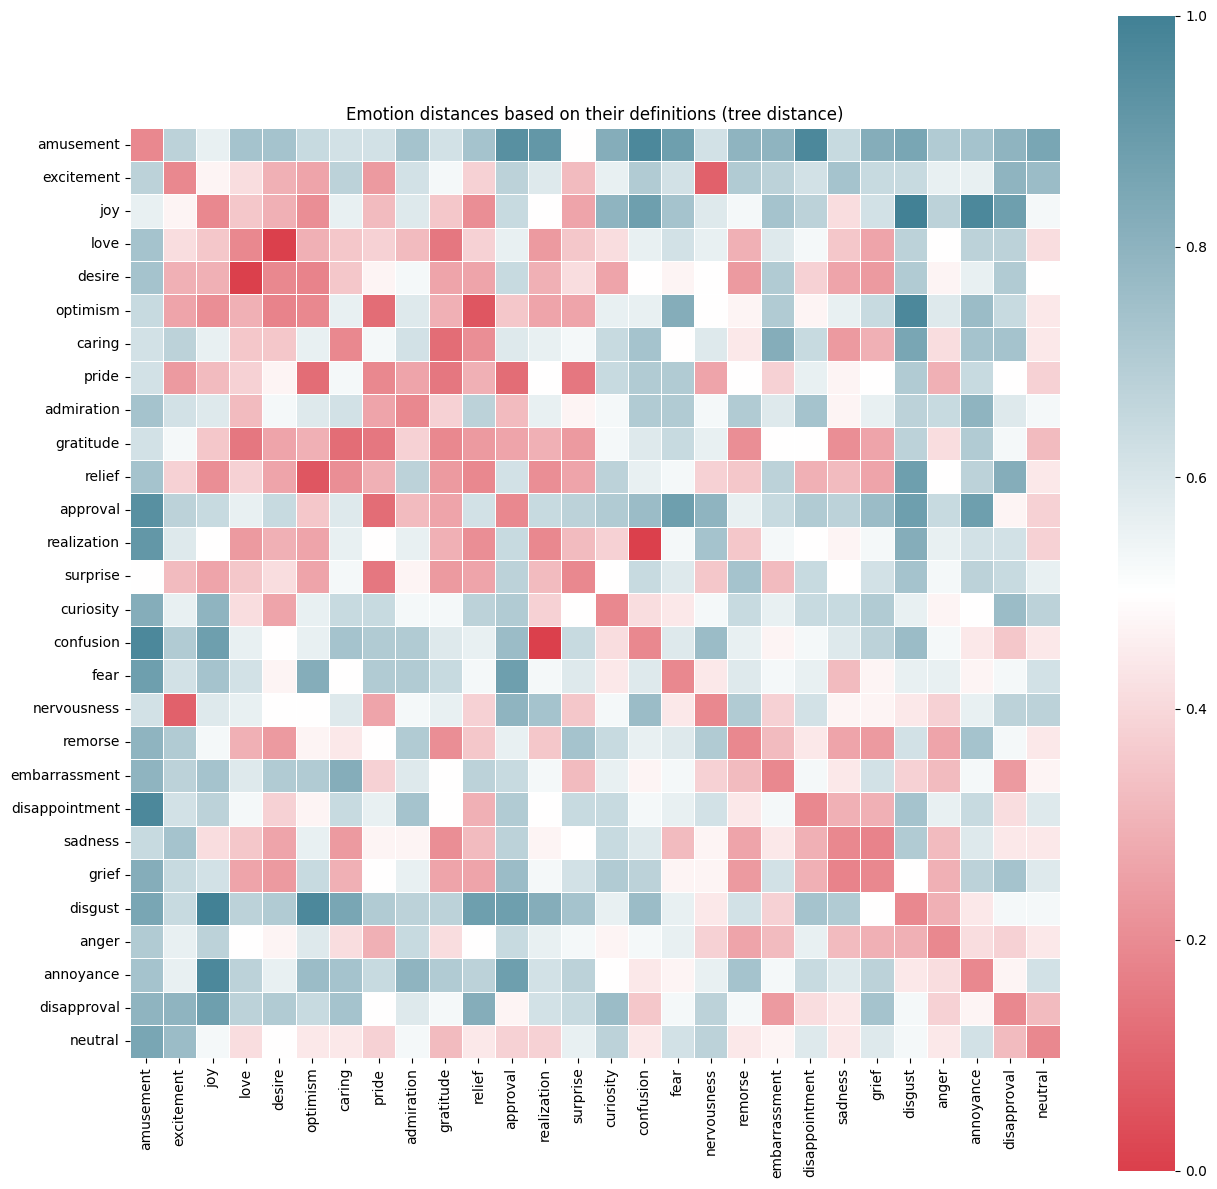

In [201]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    distances_embed,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (tree distance)")
plt.show()

### Goemotions Embeddings + Tree Distances

In [76]:
from emotion_tree import get_distance

distances_tree = np.zeros((len(emotions), len(emotions)))
for i, emotion1 in enumerate(emotions):
    for j, emotion2 in enumerate(emotions):
        distances_tree[i, j] = get_distance([emotion1], [emotion2])

# distances_tree[distances_tree < 0] = 0.5

ModuleNotFoundError: No module named 'emotion_tree'

In [10]:
import matplotlib as mpl
import seaborn as sns

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", [(0, "#db404c"), (0.5, "#ffffff"), (1, "#428195")]
)

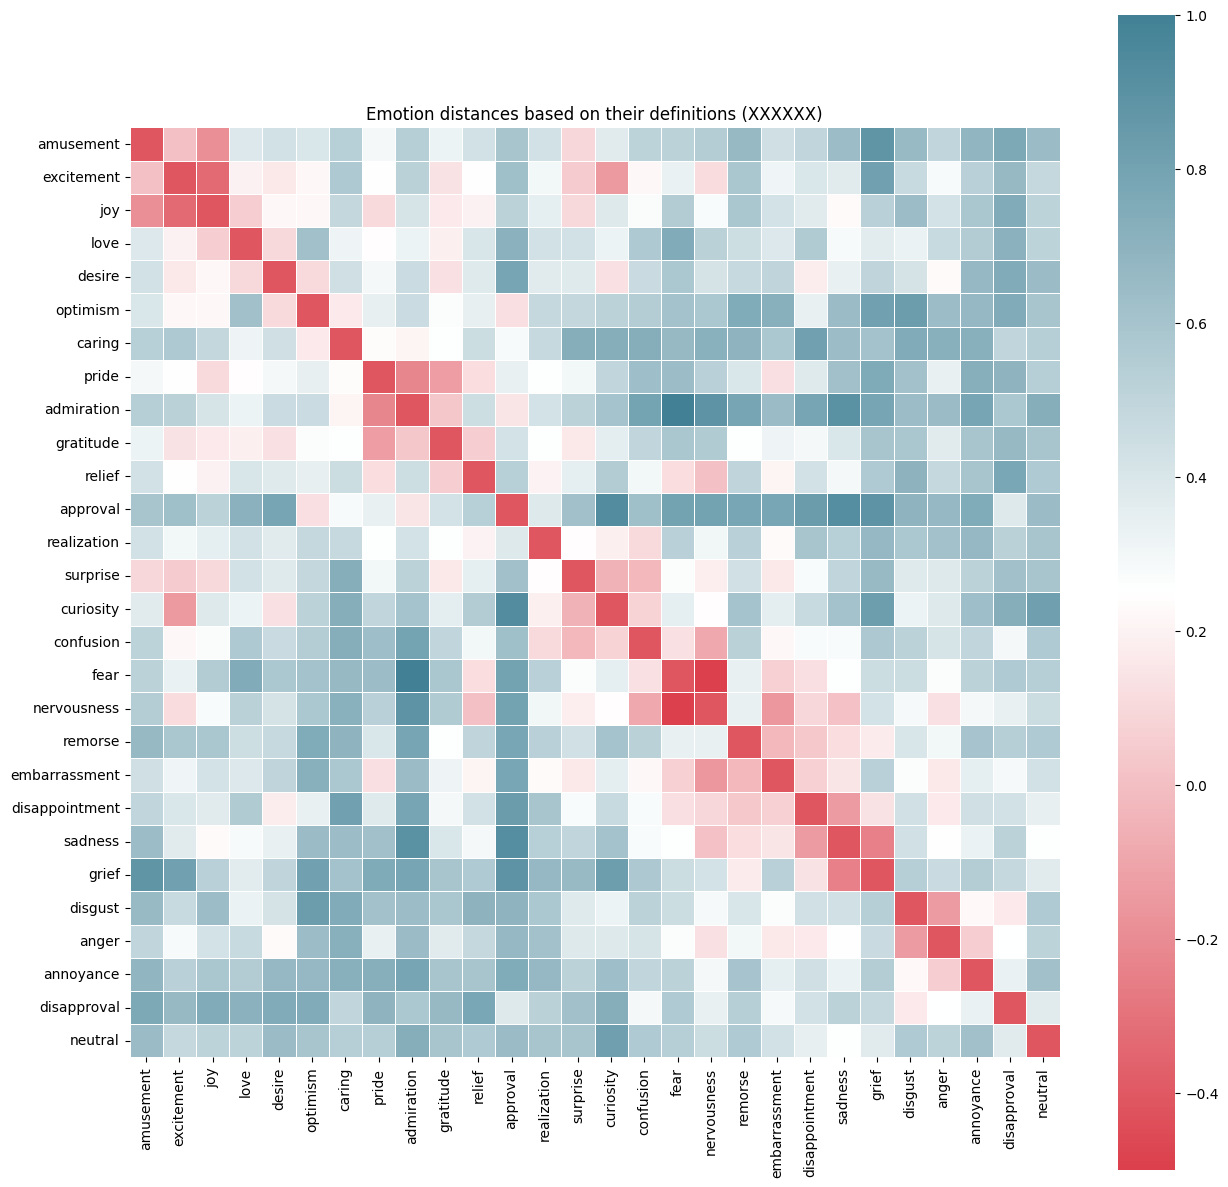

In [11]:
plt.figure(figsize=(15, 15))
beta = 0.25
combined = (distances_tree * beta) + (distances_embed * (1 - beta))
combined = (combined - combined.min()) / (combined.max() - combined.min())
combined = combined * 1.5 - 0.5  # scale values to be between -0.5 and 1


sns.heatmap(
    combined,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (XXXXXX)")
plt.show()

In [12]:
np.fill_diagonal(combined, -1)  # set diagonal to -1

In [13]:
# make a dictionary of each emotions pair and their distance
emotion_pairs = {}
for i, emotion1 in enumerate(emotions):
    for j, emotion2 in enumerate(emotions):
        emotion_pairs[(emotion1, emotion2)] = combined[i, j]

# make it into a pd dataframe with column for emotion 1 and emotion 2 and distance
import pandas as pd

df = pd.DataFrame(emotion_pairs.items(), columns=["Emotion Pair", "Distance"])
df["Emotion_1"] = df["Emotion Pair"].apply(lambda x: x[0])
df["Emotion_2"] = df["Emotion Pair"].apply(lambda x: x[1])
df = df.drop(columns=["Emotion Pair"])
df = df[["Emotion_1", "Emotion_2", "Distance"]]
df = df.sort_values(by="Distance")
df = df.reset_index(drop=True)
# sace
df.to_csv("emotion_distances.csv", index=False)

## Merriam Webster 

In [215]:
for emotion in tqdm(emotions):
    embedding = np.array([get_text_embeddings(merr_examples[emotion])])
    collection.upsert(
        ids=label2id[emotion],
        embeddings=embedding,
    )

100%|██████████| 28/28 [00:04<00:00,  6.01it/s]


### Merriam Webster only Distances

In [246]:
distances_embed = np.zeros((len(emotions), len(emotions)))
counter = 0
for emotion in emotions:
    embedding = collection.get(ids=label2id[emotion], include=["embeddings"])[
        "embeddings"
    ][0]
    result = collection.query(
        embedding, n_results=28, include=["distances", "documents"]
    )
    ids = result["ids"][0]
    indexes = [(pos, int(idx)) for pos, idx in enumerate(ids)]
    distances_inorder = []
    for i in range(len(indexes)):
        pos_in_order = list(filter(lambda x: x[1] == i, indexes))[0][0]
        distances_inorder.append(result["distances"][0][pos_in_order])
    distances_embed[counter] = np.round(np.array([distances_inorder]), 2)
    counter += 1

In [248]:
average = (distances_embed.min() + distances_embed.max()) / 2
np.fill_diagonal(distances_embed, average)
distances_embed = (distances_embed - distances_embed.min()) / (
    distances_embed.max() - distances_embed.min()
)
# np.fill_diagonal(distances_embed, 0.5)

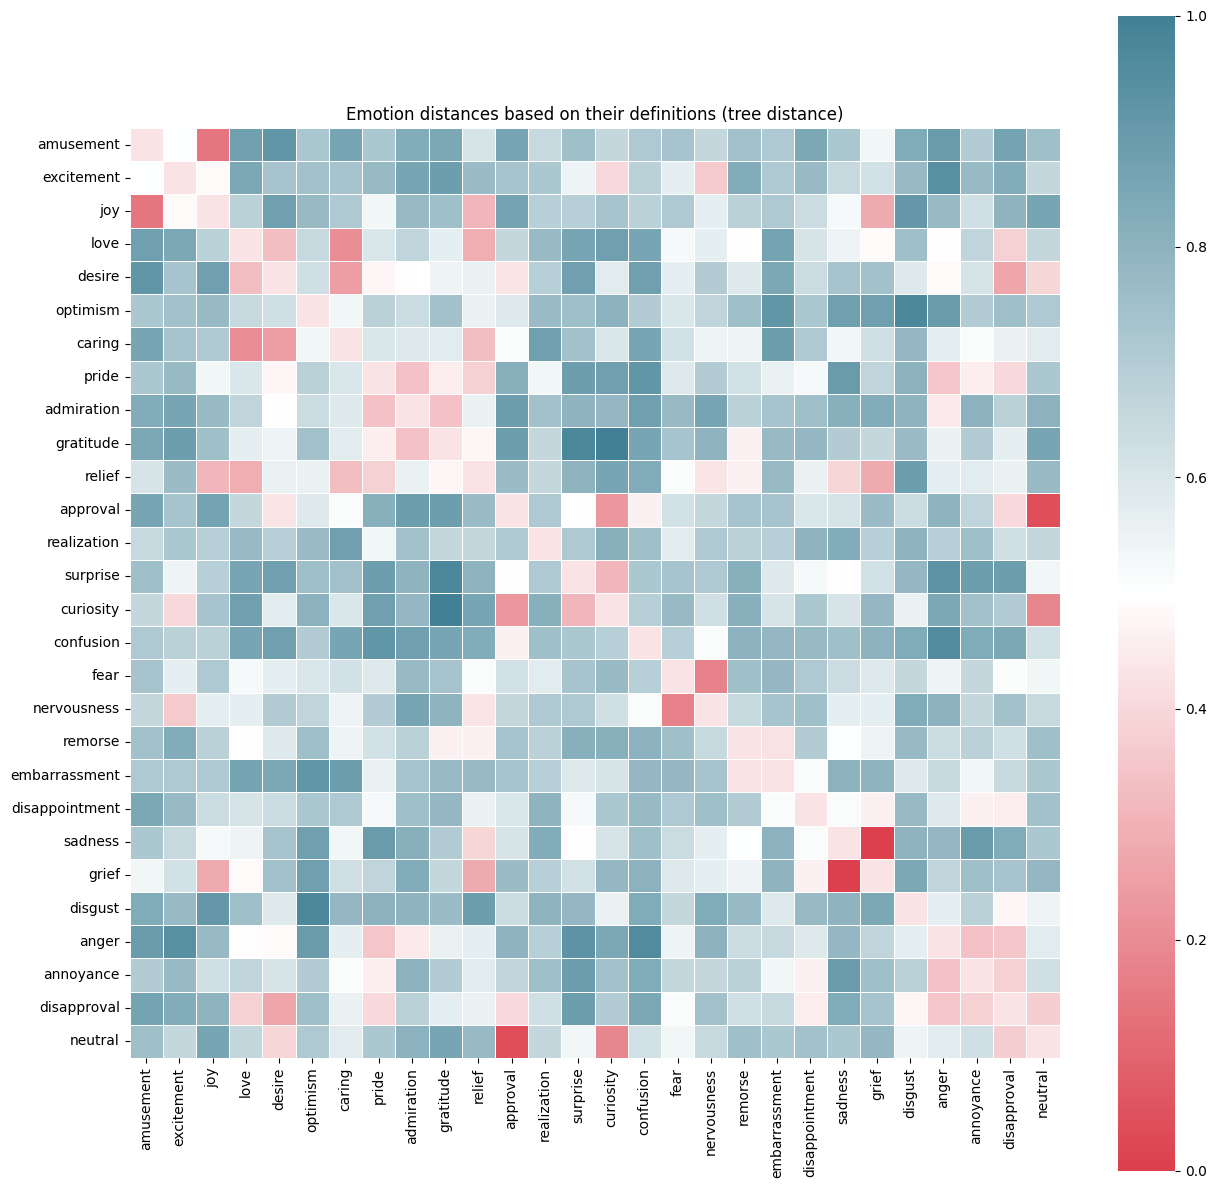

In [249]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    distances_embed,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (tree distance)")
plt.show()

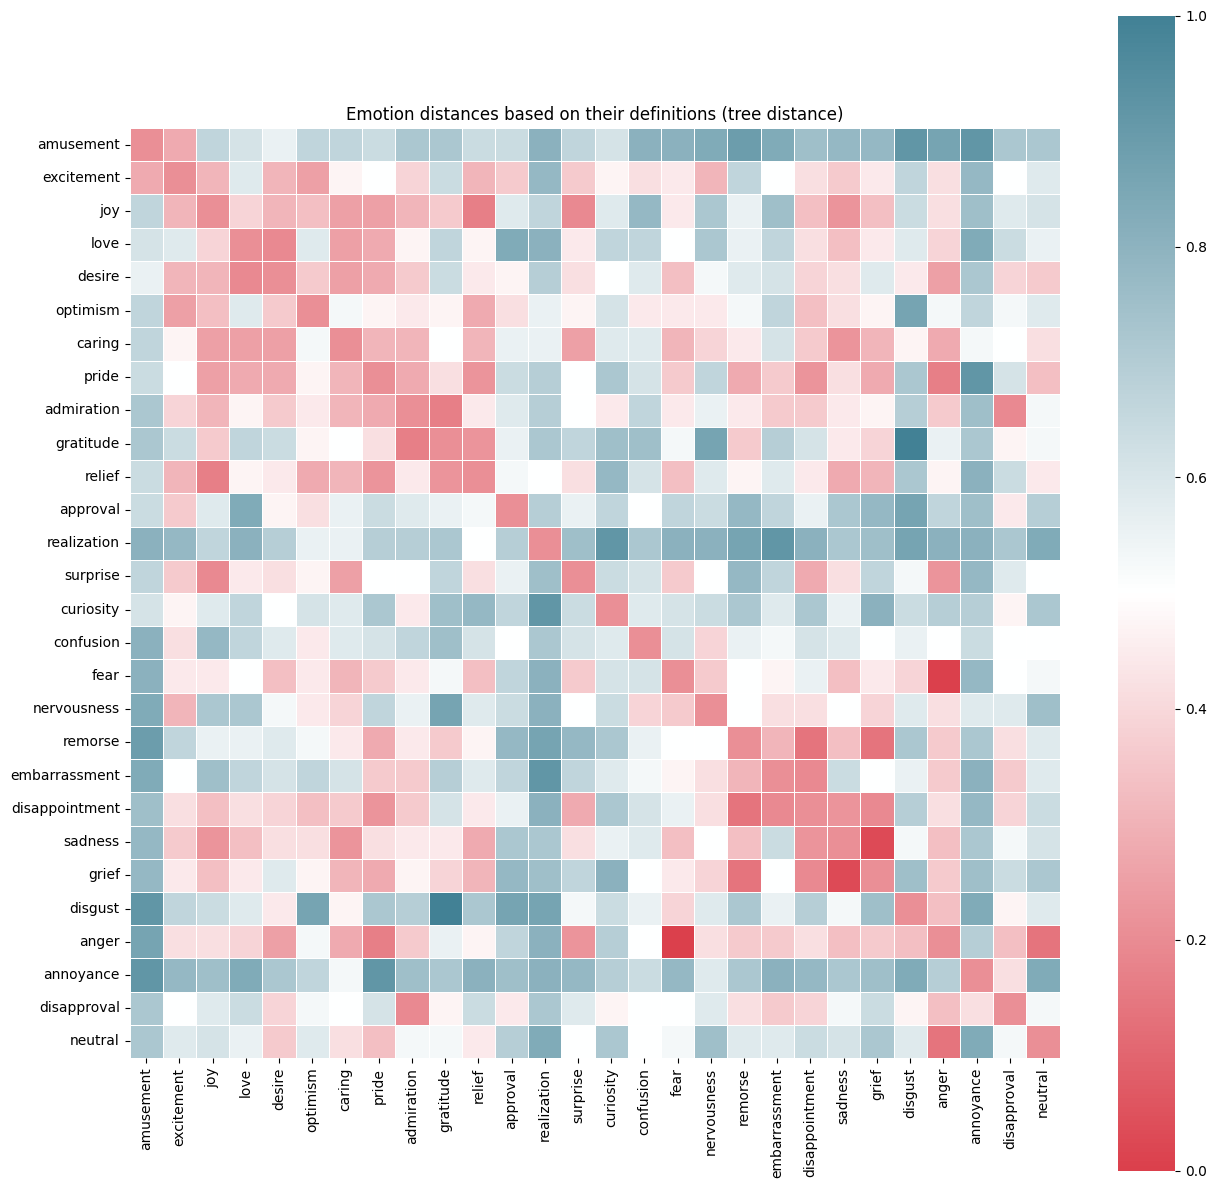

In [205]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    distances_embed,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (tree distance)")
plt.show()

# roberta-base-go_emotions

In [317]:
refined_GOemotions_definitions = {
    "admiration": "A feeling of deep respect, approval, and wonder towards someone or something due to their qualities or achievements. It encompasses sentiments of respect, esteem, veneration, awe, and reverence.",
    "amusement": "A feeling of lighthearted pleasure, entertainment, or enjoyment, often accompanied by laughter or smiles. It's characterized by mirth, glee, merriment, hilarity, and delight.",
    "anger": "A strong feeling of annoyance, displeasure, or hostility, often triggered by perceived wrongdoing or injustice. It can manifest as rage, fury, wrath, indignation, or ire.",
    "annoyance": "A feeling of slight anger or irritation caused by something that displeases, bothers, or irritates. It's akin to irritation, vexation, frustration, pique, and exasperation.",
    "approval": "A positive feeling of acceptance, agreement, or favorable regard towards something or someone. It's expressed through endorsement, sanction, support, agreement, and consent.",
    "caring": "A feeling of concern, empathy, and willingness to help or support others' well-being. It encompasses compassion, kindness, empathy, concern, and tenderness.",
    "confusion": "A state of being bewildered or unable to think clearly, often due to complexity or lack of understanding. It's characterized by bewilderment, perplexity, puzzlement, disorientation, and befuddlement.",
    "curiosity": "A strong desire to know, learn, or understand something new or unfamiliar. It's driven by inquisitiveness, interest, inquiry, wonder, and fascination.",
    "desire": "A strong feeling of wanting or wishing for something or someone, often with intensity or passion. It's expressed through longing, craving, yearning, want, and wish.",
    "disappointment": "A feeling of sadness or displeasure caused by the non-fulfillment of one's hopes or expectations. It's experienced as a letdown, frustration, disillusionment, regret, and dismay.",
    "disapproval": "A feeling or expression of condemnation or dislike towards something considered wrong or inappropriate. It's manifested through disfavor, criticism, censure, objection, and condemnation.",
    "disgust": "A feeling of strong dislike, aversion, or repugnance towards something offensive or unpleasant. It's characterized by revulsion, repugnance, abhorrence, loathing, and nausea.",
    "embarrassment": "A feeling of self-consciousness, shame, or awkwardness, often in social situations. It's experienced as mortification, humiliation, discomfort, unease, and chagrin.",
    "excitement": "A feeling of great enthusiasm, eagerness, or anticipation about something. It's expressed through thrill, elation, exhilaration, fervor, and stimulation.",
    "fear": "An unpleasant emotion caused by the threat of danger, pain, or harm, real or imagined. It manifests as dread, terror, fright, alarm, and panic.",
    "gratitude": "A warm feeling of appreciation and thankfulness for benefits received or kindness shown. It's characterized by thankfulness, appreciation, gratefulness, recognition, and indebtedness.",
    "grief": "Deep sorrow or distress, especially caused by someone's death or a significant loss. It's experienced as sorrow, heartache, anguish, mourning, and bereavement.",
    "joy": "A feeling of great happiness, pleasure, or contentment, often intense and exuberant. It's expressed through delight, elation, bliss, euphoria, and exultation.",
    "love": "An intense feeling of deep affection, attachment, or strong liking for someone or something. It encompasses adoration, devotion, fondness, affection, and passion.",
    "nervousness": "A feeling of worry, unease, or agitation, often about an imminent event or uncertain outcome. It's characterized by anxiety, apprehension, unease, tension, and jitters.",
    "optimism": "A tendency to expect the best possible outcome or to view things in a positive light. It's expressed through hopefulness, positivity, confidence, buoyancy, and sanguinity.",
    "pride": "A feeling of deep pleasure or satisfaction derived from achievements, qualities, or possessions. It's associated with self-esteem, dignity, self-respect, satisfaction, and gratification.",
    "realization": "The process of becoming fully aware of something or understanding it clearly. It involves comprehension, understanding, recognition, appreciation, and enlightenment.",
    "relief": "A feeling of reassurance and relaxation following release from anxiety or distress. It's experienced as alleviation, comfort, solace, ease, and respite.",
    "remorse": "A feeling of deep regret or guilt for a wrong committed or a sense of being conscience-stricken. It's characterized by contrition, penitence, repentance, compunction, and self-reproach.",
    "sadness": "A feeling of sorrow, unhappiness, or dejection, often accompanied by a lowered mood. It's expressed through melancholy, sorrow, dejection, despondency, and glumness.",
    "surprise": "A feeling of sudden astonishment or wonder caused by something unexpected. It's characterized by amazement, astonishment, shock, startlement, and wonder.",
    "neutral": "A state of emotional balance, neither positive nor negative, without strong feelings in any direction. It's associated with being impartial, unbiased, indifferent, dispassionate, and objective.",
}

In [157]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained(
    "SamLowe/roberta-base-go_emotions"
).to(device)

In [214]:
def get_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=512
    )
    inputs.to(device)

    # Get the model outputs
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract the embeddings from the last hidden state
    # This is the layer just before the classification layer
    embeddings = outputs.hidden_states[-1][:, 0, :].squeeze()

    return embeddings.tolist()

In [318]:
for emotion in tqdm(emotions):
    embedding = np.array([get_embeddings(refined_GOemotions_definitions[emotion])])
    collection.upsert(
        ids=label2id[emotion],
        embeddings=embedding,
    )

100%|██████████| 28/28 [00:01<00:00, 20.66it/s]


In [323]:
distances_embed = np.zeros((len(emotions), len(emotions)))
counter = 0
for emotion in emotions:
    embedding = collection.get(ids=label2id[emotion], include=["embeddings"])[
        "embeddings"
    ][0]
    result = collection.query(
        embedding, n_results=28, include=["distances", "documents"]
    )
    ids = result["ids"][0]
    indexes = [(pos, int(idx)) for pos, idx in enumerate(ids)]
    distances_inorder = []
    for i in range(len(indexes)):
        pos_in_order = list(filter(lambda x: x[1] == i, indexes))[0][0]
        distances_inorder.append(result["distances"][0][pos_in_order])
    distances_embed[counter] = np.round(np.array([distances_inorder]), 2)
    counter += 1

In [321]:
average = (distances_embed.min() + distances_embed.max()) / 2
np.fill_diagonal(distances_embed, average)
distances_embed = (distances_embed - distances_embed.min()) / (
    distances_embed.max() - distances_embed.min()
)
# np.fill_diagonal(distances_embed, 0.5)

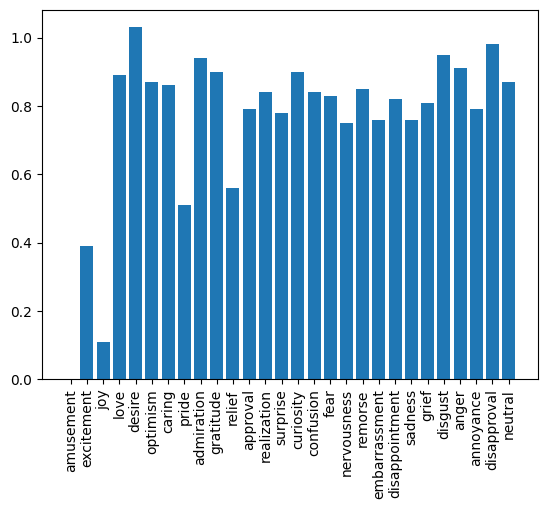

In [324]:
plt.bar(emotions, distances_embed[0])
# x ticks vertical
plt.xticks(rotation=90)

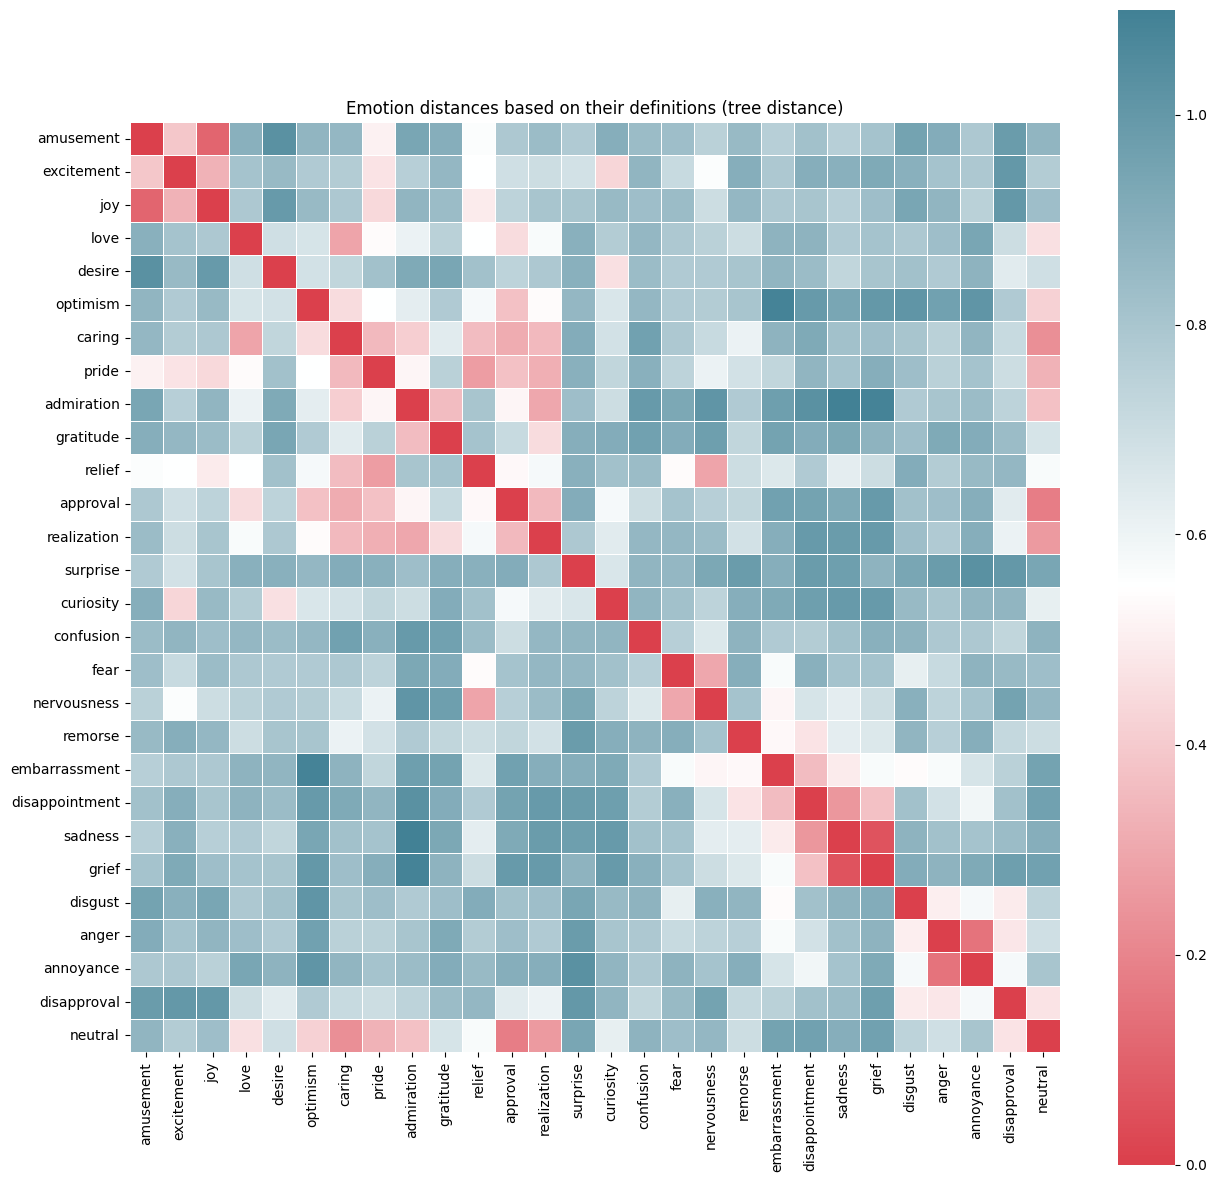

In [325]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    distances_embed,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (tree distance)")
plt.show()